# 2 input AND, OR, NOT

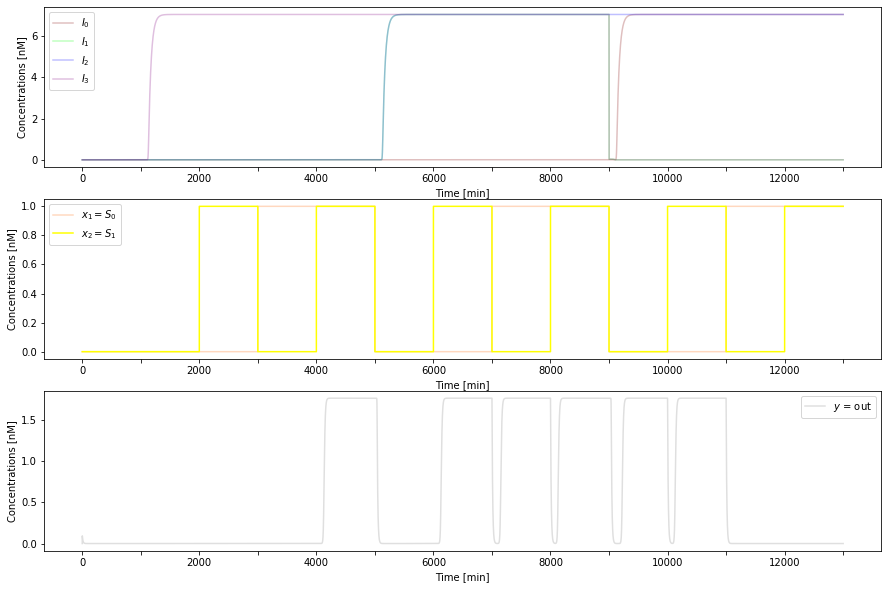

In [19]:
from scipy.integrate import ode
import matplotlib.pyplot as plt

from models import *
from parameters import *


"""
[[(S1, I1)], []]
"""
"""
states = [([0,0], [0,0,0,0]), ([0,0], [1,0,0,0]), 
          ([1,0], [0,0,0,0]), ([1,0], [0,1,0,0]), 
          ([0,1], [0,0,0,0]), ([0,1], [0,0,1,0]), 
          ([1,1], [0,0,0,0]), ([1,1], [0,0,0,1])]
"""        

"""
states = [([0,0], [0,0,0,0]), ([0,0], [1,0,0,0]), 
          ([1,0], [1,0,0,0]), ([1,0], [1,1,0,0]), 
          ([0,1], [1,1,0,0]), ([0,1], [1,1,1,0]), 
          ([1,1], [1,1,1,0]), ([1,1], [1,1,1,1])]

"""
states_null = [([0,0], [0,0,0,0])]

states_AND = [([0,0], [0,0,0,1]), 
              ([0,1], [0,0,0,1]),
              ([1,0], [0,0,0,1]),
              ([1,1], [0,0,0,1])]

states_OR = [([0,0], [0,1,1,1]), 
             ([0,1], [0,1,1,1]),
             ([1,0], [0,1,1,1]),
             ([1,1], [0,1,1,1])]

states_NOT = [([0,0], [1,0,1,0]), 
              ([0,1], [1,0,1,0]),
              ([1,0], [1,0,1,0]),
              ([1,1], [1,0,1,0])]

states_XOR = [([0,0], [0,1,1,0]), 
              ([0,1], [0,1,1,0]),
              ([1,0], [0,1,1,0]),
              ([1,1], [0,1,1,0])]
 


states = states_null + states_AND + states_OR + states_NOT


# simulation parameters (for a single state)
t_end = 1000
N = t_end

rho_x = 0
rho_y = 0

"""
rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = 0, 5, 5, 0, 5, 0, 5, 0

params = (delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, 
         rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b)
"""

Y0 = np.zeros(59)

# number of cells: toggle switches
N_I0 = np.array([1,1])
N_I1 = np.array([1,1])
N_I2 = np.array([1,1])
N_I3 = np.array([1,1])

Y0[4:6] = N_I0
Y0[10:12] = N_I1
Y0[16:18] = N_I2
Y0[22:24] = N_I3

# number of cells: mux
#Y0[22-4+24:38-4+24] = 1 # number of cells
Y0[42:58] = 1 # number of cells



"""
simulations
"""

for iteration, state in enumerate(states):
    
    S = state[0]
    I = state[1]
    I0, I1, I2, I3 = I


    if iteration > 0 and states[iteration-1][1] == I:
        #rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = (1-I0) * 5, I0*5, (1-I1)*5, I1*5, (1-I2)*5, I2*5, (1-I3)*5, I3*5
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = 0, 0, 0, 0, 0, 0, 0, 0        
    else:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = (1-I0) * 5, I0*5, (1-I1)*5, I1*5, (1-I2)*5, I2*5, (1-I3)*5, I3*5
        
    
    rho_x, rho_y = 0,0
    params = (delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, 
         rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b)

    if iteration:
        Y0 = Y_last[-1,:]
    
    Y0[24:26] = S

    # initialization

    T = np.linspace(0, t_end, N)

    t1 = t_end
    dt = t_end/N
    T = np.arange(0,t1+dt,dt)
    Y = np.zeros([1+N,59])
    Y[0,:] = Y0


    # simulation
    r = ode(CLB_model_ODE).set_integrator('zvode', method='bdf')
    r.set_initial_value(Y0, T[0]).set_f_params(params)

    i = 1
    while r.successful() and r.t < t1:
        Y[i,:] = r.integrate(r.t+dt)
        i += 1

        # hold the state after half of the simulation time!
        if r.t > t1/2:
            params = (delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, 
            0, 0, 0, 0, 0, 0, 0, 0)
            r.set_f_params(params)

    Y_last = Y
    if not iteration:
        Y_full = Y
        T_full = T
    else:
        Y_full = np.append(Y_full, Y, axis = 0)
        T_full = np.append(T_full, T + iteration * t_end, axis = 0)

Y = Y_full
T = T_full

S0, S1 = Y[:,24], Y[:,25]

I0_a, I0_b = Y[:,2], Y[:,3]
I1_a, I1_b = Y[:,8], Y[:,9]
I2_a, I2_b = Y[:,14], Y[:,15]
I3_a, I3_b = Y[:,20], Y[:,21]

out = Y[:,-1]

# plot

ax1 = plt.subplot(311)
ax1.plot(T, I0_a, color="#800000ff", alpha=0.25)
ax1.plot(T, I1_a, color = "#00ff00ff", alpha=0.25)
ax1.plot(T, I2_a, color = "#0000ffff", alpha=0.25)
ax1.plot(T, I3_a, color = "#800080ff", alpha=0.25)

ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Concentrations [nM]")

ax1.legend(["$I_0$", "$I_1$", "$I_2$", "$I_3$"])
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Concentrations [nM]")



ax5 = plt.subplot(312)
ax5.plot(T,S0, color = "#ff6600ff", alpha=0.25)
ax5.plot(T,S1, color = "#ffff00ff")#, alpha=0.75)
ax5.legend(["$x_1 = S_0$", "$x_2 = S_1$"])
#ax5.set_title('Select inputs')
ax5.set_xlabel("Time [min]")
ax5.set_ylabel("Concentrations [nM]")


ax6 = plt.subplot(313)
ax6.plot(T,out, color = "#8080805a", alpha=0.25)
#ax6.set_title('out')
ax6.legend(['$y$ = out'])
ax6.set_xlabel("Time [min]")
ax6.set_ylabel("Concentrations [nM]")

ticks = np.arange(0,14,1)*1000
tick_labels = list(map(str,ticks))
for i in range(len(tick_labels)):
    if i%2==1:
        tick_labels[i]=""

ax1.set_xticks(ticks)
ax5.set_xticks(ticks)
ax6.set_xticks(ticks)

ax1.set_xticklabels(tick_labels)
ax5.set_xticklabels(tick_labels)
ax6.set_xticklabels(tick_labels)

#plt.suptitle("$out = \\overline{S}_1 \\overline{S}_0 I_0 \\vee \\overline{S}_1 S_0 I_1 \\vee S_1 \\overline{S}_0 I_2 \\vee S_1 S_0 I_3$")
plt.gcf().set_size_inches(15,10)
# plt.savefig("figs/AND_OR_NOT_ode.pdf", bbox_inches = 'tight')

plt.show() 

# 3 input AND, OR, XOR

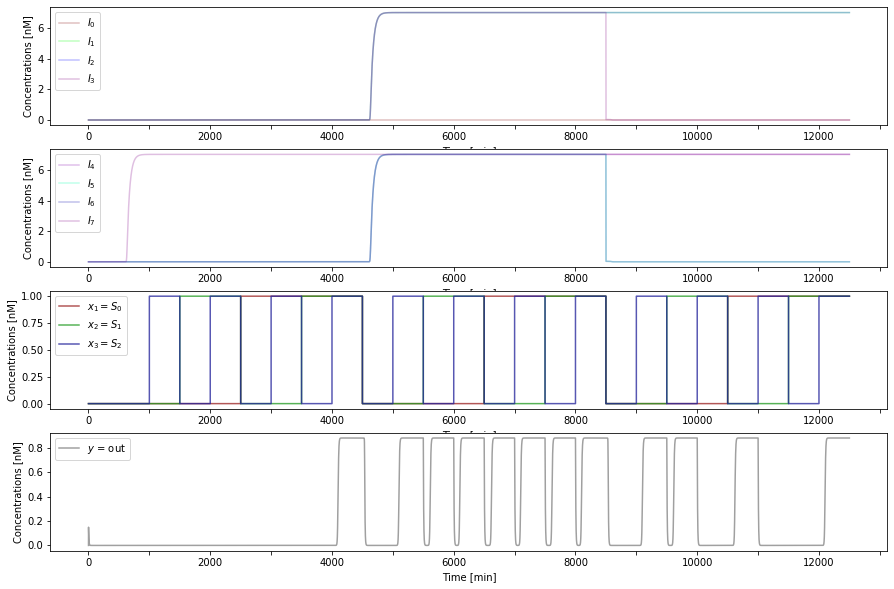

In [32]:
from scipy.integrate import ode
import matplotlib.pyplot as plt

from models import *
from model_mux_8_1 import *
from parameters import *

states_null = [([0,0,0], [0,0,0,0,0,0,0,0])]

states_AND = [([0,0,0], [0,0,0,0,0,0,0,1]),
              ([0,0,1], [0,0,0,0,0,0,0,1]),
              ([0,1,0], [0,0,0,0,0,0,0,1]),
              ([0,1,1], [0,0,0,0,0,0,0,1]),
              ([1,0,0], [0,0,0,0,0,0,0,1]),
              ([1,0,1], [0,0,0,0,0,0,0,1]),
              ([1,1,0], [0,0,0,0,0,0,0,1]),
              ([1,1,1], [0,0,0,0,0,0,0,1])]

states_OR = [([0,0,0], [0,1,1,1,1,1,1,1]),
             ([0,0,1], [0,1,1,1,1,1,1,1]),
             ([0,1,0], [0,1,1,1,1,1,1,1]),
             ([0,1,1], [0,1,1,1,1,1,1,1]),
             ([1,0,0], [0,1,1,1,1,1,1,1]),
             ([1,0,1], [0,1,1,1,1,1,1,1]),
             ([1,1,0], [0,1,1,1,1,1,1,1]),
             ([1,1,1], [0,1,1,1,1,1,1,1])]

states_XOR = [([0,0,0], [0,1,1,0,1,0,0,1]),
              ([0,0,1], [0,1,1,0,1,0,0,1]),
              ([0,1,0], [0,1,1,0,1,0,0,1]),
              ([0,1,1], [0,1,1,0,1,0,0,1]),
              ([1,0,0], [0,1,1,0,1,0,0,1]),
              ([1,0,1], [0,1,1,0,1,0,0,1]),
              ([1,1,0], [0,1,1,0,1,0,0,1]),
              ([1,1,1], [0,1,1,0,1,0,0,1])]

states = states_null + states_AND + states_OR + states_XOR
# states = states_XOR

# simulation parameters (for a single state)
t_end = 500
N = t_end

rho_x = 0
rho_y = 0

Y0 = np.zeros(128)

# number of cells: toggle switches
N_I0 = np.array([1,1])
N_I1 = np.array([1,1])
N_I2 = np.array([1,1])
N_I3 = np.array([1,1])
N_I4 = np.array([1,1])
N_I5 = np.array([1,1])
N_I6 = np.array([1,1])
N_I7 = np.array([1,1])

Y0[4:6] = N_I0
Y0[10:12] = N_I1
Y0[16:18] = N_I2
Y0[22:24] = N_I3
Y0[28:30] = N_I4
Y0[34:36] = N_I5
Y0[40:42] = N_I6
Y0[46:48] = N_I7

# number of cells: mux 8/1 = 40
Y0[87:127] = 1 # number of cells

"""
simulations
"""
for iteration, state in enumerate(states):
    S = state[0]
    I = state[1]
    I0, I1, I2, I3, I4, I5, I6, I7 = I

    if iteration > 0 and states[iteration-1][1] == I:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = 0, 0, 0, 0, 0, 0, 0, 0
        rho_I4_a, rho_I4_b, rho_I5_a, rho_I5_b, rho_I6_a, rho_I6_b, rho_I7_a, rho_I7_b = 0, 0, 0, 0, 0, 0, 0, 0
    else:
        rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b = (1-I0) * 5, I0*5, (1-I1)*5, I1*5, (1-I2) * 5, I2*5, (1-I3)*5, I3*5
        rho_I4_a, rho_I4_b, rho_I5_a, rho_I5_b, rho_I6_a, rho_I6_b, rho_I7_a, rho_I7_b = (1-I4) * 5, I4*5, (1-I5)*5, I5*5, (1-I6) * 5, I6*5, (1-I7)*5, I7*5
        
    
    rho_x, rho_y = 0,0
    params = (delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, rho_I0_a, rho_I0_b, rho_I1_a, rho_I1_b, rho_I2_a, rho_I2_b, rho_I3_a, rho_I3_b, rho_I4_a, rho_I4_b, rho_I5_a, rho_I5_b, rho_I6_a, rho_I6_b, rho_I7_a, rho_I7_b)

    if iteration:
        Y0 = Y_last[-1,:]

    Y0[48:51] = S

    # initialization
    T = np.linspace(0, t_end, N)

    t1 = t_end
    dt = t_end/N
    T = np.arange(0,t1+dt,dt)
    Y = np.zeros([1+N,128])
    Y[0,:] = Y0


    # simulation
    r = ode(CLB_model_MUX_8_1_ODE).set_integrator('zvode', method='bdf')
    r.set_initial_value(Y0, T[0]).set_f_params(params)
    i = 1
    while r.successful() and r.t < t1:
        Y[i,:] = r.integrate(r.t+dt)
        i += 1

        # hold the state after half of the simulation time!
        if r.t > t1/2:
            params = (delta_L, gamma_L_X, n_y, theta_L_X, eta_x, omega_x, m_x, delta_x, delta_y, rho_x, rho_y, gamma_x, theta_x, r_X, r_Y, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
            r.set_f_params(params)

    Y_last = Y
    if not iteration:
        Y_full = Y
        T_full = T
    else:
        Y_full = np.append(Y_full, Y, axis = 0)
        T_full = np.append(T_full, T + iteration * t_end, axis = 0)

Y = Y_full
T = T_full

S0, S1, S2 = Y[:,48], Y[:,49], Y[:,50]
I0_a, I0_b = Y[:,2], Y[:,3]
I1_a, I1_b = Y[:,8], Y[:,9]
I2_a, I2_b = Y[:,14], Y[:,15]
I3_a, I3_b = Y[:,20], Y[:,21]
I4_a, I4_b = Y[:,26], Y[:,27]
I5_a, I5_b = Y[:,32], Y[:,33]
I6_a, I6_b = Y[:,38], Y[:,39]
I7_a, I7_b = Y[:,44], Y[:,45]

out = Y[:,-1]

ax1 = plt.subplot(411)
ax1.plot(T, I0_a, color="#800000ff", alpha=0.25)
ax1.plot(T, I1_a, color = "#00ff00ff", alpha=0.25)
ax1.plot(T, I2_a, color = "#0000ffff", alpha=0.25)
ax1.plot(T, I3_a, color = "#800080ff", alpha=0.25)
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Concentrations [nM]")

ax1.legend(["$I_0$", "$I_1$", "$I_2$", "$I_3$"])
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Concentrations [nM]")

ax2 = plt.subplot(412)
ax2.plot(T, I4_a, color="#8000aaff", alpha=0.25)
ax2.plot(T, I5_a, color = "#00ffaaff", alpha=0.25)
ax2.plot(T, I6_a, color = "#0000aaff", alpha=0.25)
ax2.plot(T, I7_a, color = "#800088ff", alpha=0.25)
ax2.set_xlabel("Time [min]")
ax2.set_ylabel("Concentrations [nM]")

ax2.legend(["$I_4$", "$I_5$", "$I_6$", "$I_7$"])
ax2.set_xlabel("Time [min]")
ax2.set_ylabel("Concentrations [nM]")

ax5 = plt.subplot(413)
ax5.plot(T,S0, color = "#991f1f", alpha=0.75)
ax5.plot(T,S1, color = "#1f991f", alpha=0.75)
ax5.plot(T,S2, color = "#1f1f99", alpha=0.75)
ax5.legend(["$x_1 = S_0$", "$x_2 = S_1$", "$x_3 = S_2$"])
#ax5.set_title('Select inputs')
ax5.set_xlabel("Time [min]")
ax5.set_ylabel("Concentrations [nM]")


ax6 = plt.subplot(414)
ax6.plot(T,out, color = "#8080805a", alpha=0.75)
#ax6.set_title('out')
ax6.legend(['$y$ = out'])
ax6.set_xlabel("Time [min]")
ax6.set_ylabel("Concentrations [nM]")

ticks = np.arange(0,14,1)*1000
tick_labels = list(map(str,ticks))
for i in range(len(tick_labels)):
    if i%2==1:
        tick_labels[i]=""

ax1.set_xticks(ticks)
ax2.set_xticks(ticks)
ax5.set_xticks(ticks)
ax6.set_xticks(ticks)

ax1.set_xticklabels(tick_labels)
ax2.set_xticklabels(tick_labels)
ax5.set_xticklabels(tick_labels)
ax6.set_xticklabels(tick_labels)

plt.gcf().set_size_inches(15,10)
plt.savefig("figs/AND_OR_XOR_ode.pdf", bbox_inches = 'tight')

plt.show()